# Demo example: Using a Google Earth engine


This example is the continuation of the previous example: [Using a Dataset](https://metobs-toolkit.readthedocs.io/en/latest/examples/doc_example.html). This example serves as a demonstration on how to get meta-data from the Google Earth Engine (GEE). 

Before proceeding, make sure you have **set up a Google developers account and a GEE project**. See [Using Google Earth Engine](https://metobs-toolkit.readthedocs.io/en/latest/topics/gee_authentication.html#using-google-earth-engine) for a detailed description of this.

## Create your Dataset

Create a dataset with the demo data.

In [1]:
import metobs_toolkit

your_dataset = metobs_toolkit.Dataset()
your_dataset.update_settings(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

your_dataset.import_data_from_file()

LOG:: metobs_toolkit - INFO - Logger initiated
LOG:: metobs_toolkit.dataset_core - INFO - Initialise dataset
LOG:: metobs_toolkit.datasetbase - INFO - Initialise dataset
LOG:: metobs_toolkit.settings - INFO - Initialising settings
LOG:: metobs_toolkit.settings - DEBUG - Updating app settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating QC settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating gee settings.
LOG:: metobs_toolkit.settings - INFO - Updating settings with input: 
LOG:: metobs_toolkit.settings - INFO - Update input_data_file:  None  -->  /home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_datafile.csv
LOG:: metobs_toolkit.settings - INFO - Update meta_data_file:  None  -->  /home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_metadatafile.csv
LOG:: metobs_toolkit.settings - INFO - Update template file:  None  -->  /home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_temp

## Extracting LCZ from GEE

Here is an example of how to extract the Local Climate Zone (LCZ) information of your stations. First, we take a look at what is present in the metadata of the dataset. 

In [2]:
your_dataset.metadf.head()

,lat,lon,school,geometry,dataset_resolution,dt_start,dt_end
name,,,,,,,
vlinder01,50.980438,3.815763,UGent,POINT (3.81576 50.98044),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder02,51.022379,3.709695,UGent,POINT (3.7097 51.02238),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder03,51.324583,4.952109,Heilig Graf,POINT (4.95211 51.32458),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder04,51.335522,4.934732,Heilig Graf,POINT (4.93473 51.33552),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00
vlinder05,51.052655,3.675183,Sint-Barbara,POINT (3.67518 51.05266),0 days 00:05:00,2022-09-01 00:00:00+00:00,2022-09-15 23:55:00+00:00


To extract geospatial information for your stations, the **lat** and **lon** (latitude and longitude)
of your stations must be present in the metadf. If so, than geospatial
information will be extracted from GEE at these locations.

To extract the Local Climate Zones (LCZs) of your stations:

In [3]:
lcz_values = your_dataset.get_lcz()
# The LCZs for all your stations are extracted
print(lcz_values)

/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.10/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for RUB/RUBCLIM/LCZ/global_lcz_map/v1! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/RUB_RUBCLIM_LCZ_global_lcz_map_v1

  warnings.warn(warning, category=DeprecationWarning)


name
vlinder01         Low plants (LCZ D)
vlinder02               Open midrise
vlinder03               Open midrise
vlinder04             Sparsely built
vlinder05              Water (LCZ G)
vlinder06    Scattered Trees (LCZ B)
vlinder07            Compact midrise
vlinder08            Compact midrise
vlinder09    Scattered Trees (LCZ B)
vlinder10            Compact midrise
vlinder11               Open lowrise
vlinder12              Open highrise
vlinder13            Compact midrise
vlinder14         Low plants (LCZ D)
vlinder15             Sparsely built
vlinder16              Water (LCZ G)
vlinder17    Scattered Trees (LCZ B)
vlinder18         Low plants (LCZ D)
vlinder19            Compact midrise
vlinder20            Compact midrise
vlinder21             Sparsely built
vlinder22         Low plants (LCZ D)
vlinder23         Low plants (LCZ D)
vlinder24        Dense Trees (LCZ A)
vlinder25              Water (LCZ G)
vlinder26               Open midrise
vlinder27            Compact midr

The first time, in each session, you are asked to authenticated by Google.
Select your Google account and billing project that you have set up and accept the terms of the condition.

*NOTE: For small data-requests the read-only scopes are sufficient, for large data-requests this is insufficient because the data will be written directly to your Google Drive.*

The metadata of your dataset is also updated

In [4]:
print(your_dataset.metadf['lcz'].head())

name
vlinder01    Low plants (LCZ D)
vlinder02          Open midrise
vlinder03          Open midrise
vlinder04        Sparsely built
vlinder05         Water (LCZ G)
Name: lcz, dtype: object


To make a geospatial plot you can use the following method:

LOG:: metobs_toolkit.dataset_visuals - INFO - Make lcz-geo plot at 2022-09-01 00:00:00+00:00


<GeoAxes: title={'center': 'lcz'}>

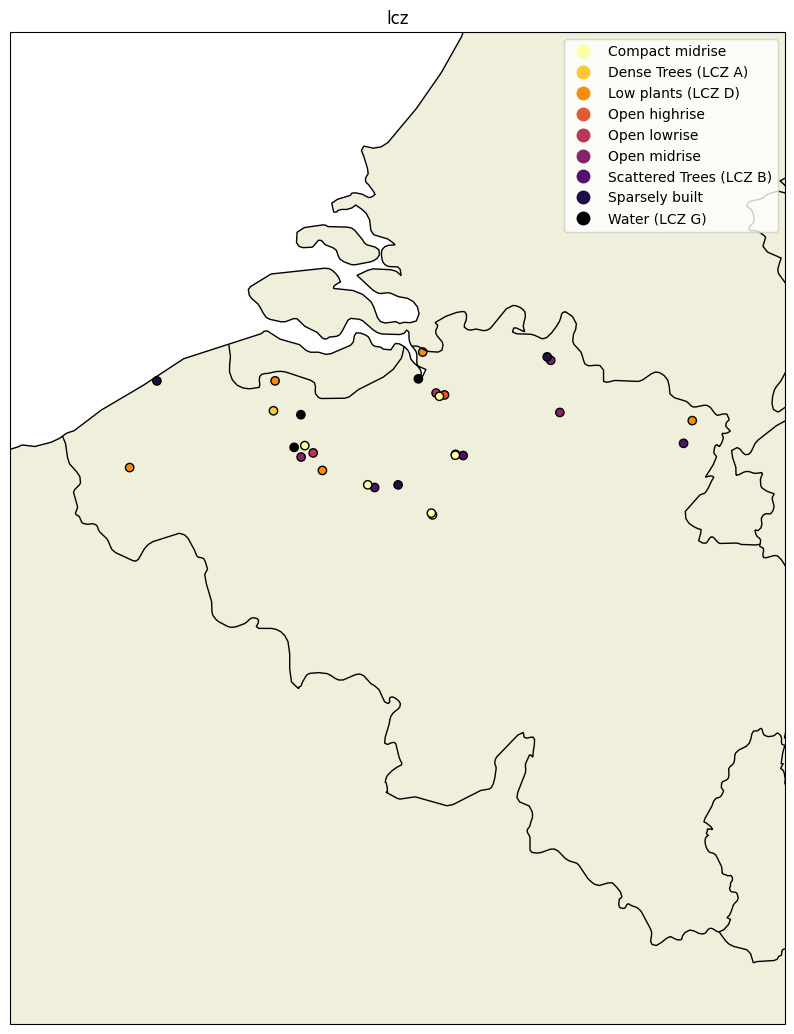

In [5]:
your_dataset.make_geo_plot(variable="lcz")

## Extracting other Geospatial information

Similar as LCZ extraction you can extract the altitude of the stations (from a digital elevation model):

In [6]:
altitudes = your_dataset.get_altitude() #The altitudes are in meters above sea level.
print(altitudes)

name
vlinder01    12
vlinder02     7
vlinder03    30
vlinder04    25
vlinder05     0
vlinder06     0
vlinder07     7
vlinder08     7
vlinder09    19
vlinder10    14
vlinder11     6
vlinder12     9
vlinder13    10
vlinder14     4
vlinder15    41
vlinder16     4
vlinder17    83
vlinder18    35
vlinder19    75
vlinder20    44
vlinder21    19
vlinder22     3
vlinder23     1
vlinder24    12
vlinder25    12
vlinder26    24
vlinder27    12
vlinder28     7
Name: altitude, dtype: int64


A more detailed description of the landcover/land use in the microenvironment can be extracted in the form of landcover fractions in a circular buffer for each station.

You can select to aggregate the landcover classes to water - pervious and impervious, or set aggregation to false to extract the landcover classes as present in the worldcover_10m dataset.

In [7]:
aggregated_landcover = your_dataset.get_landcover(
                                        buffers=[100, 250], # a list of buffer radii in meters
                                        aggregate=True #if True, aggregate landcover classes to the water, pervious and impervious.
                                        )

print(aggregated_landcover)

LOG:: metobs_toolkit.dataset_core - INFO - Extracting landcover from worldcover with buffer radius = 100
LOG:: metobs_toolkit.landcover_functions - INFO - Using aggregation scheme: {'water': [70, 80, 90, 95], 'pervious': [10, 20, 30, 40, 60, 100], 'impervious': [50]}
LOG:: metobs_toolkit.dataset_core - INFO - Extracting landcover from worldcover with buffer radius = 250
LOG:: metobs_toolkit.landcover_functions - INFO - Using aggregation scheme: {'water': [70, 80, 90, 95], 'pervious': [10, 20, 30, 40, 60, 100], 'impervious': [50]}


                            water  pervious  impervious
name      buffer_radius                                
vlinder01 100            0.000000  0.981781    0.018219
          250            0.000000  0.963635    0.036365
vlinder02 100            0.000000  0.428769    0.571231
          250            0.000000  0.535944    0.464056
vlinder03 100            0.000000  0.245454    0.754546
          250            0.000000  0.160831    0.839169
vlinder04 100            0.000000  0.979569    0.020431
          250            0.000000  0.881948    0.118052
vlinder05 100            0.446604  0.224871    0.328525
          250            0.242406  0.526977    0.230617
vlinder06 100            0.000000  1.000000    0.000000
          250            0.000000  0.995819    0.004181
vlinder07 100            0.000000  0.433034    0.566966
          250            0.002911  0.149681    0.847407
vlinder08 100            0.000000  0.029552    0.970448
          250            0.002911  0.030423    0

## Extracting ERA5 timeseries

The toolkit has built-in functionality to extract ERA5 time series at the station locations. The ERA5 data will be stored in a [Modeldata](https://metobs-toolkit.readthedocs.io/en/latest/reference/modeldata.html) instance. Here is an example on how to get the ERA5 time series by using the ``get_modeldata()`` method.


In [8]:
#Get the ERA5 data for a single station (to reduce data transfer)
your_station = your_dataset.get_station('vlinder02')

#Extract time series at the location of the station
ERA5_data = your_station.get_modeldata(modelname='ERA5_hourly', 
                                      obstype='temp', 
                                      startdt=None, #if None, the start of the observations is used 
                                      enddt=None, #if None, the end of the observations is used 
                                      )

#Get info
print(ERA5_data)
ERA5_data.make_plot(obstype_model='temp', 
                    dataset=your_station, #add the observations to the same plot 
                    obstype_dataset='temp')


LOG:: metobs_toolkit.dataset_core - INFO - Extract vlinder02 from dataset.
LOG:: metobs_toolkit.dataset_core - INFO - Initialise dataset
LOG:: metobs_toolkit.datasetbase - INFO - Initialise dataset
LOG:: metobs_toolkit.settings - INFO - Initialising settings
LOG:: metobs_toolkit.settings - DEBUG - Updating app settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating QC settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating gee settings.
LOG:: metobs_toolkit.settings - INFO - Initialising settings
LOG:: metobs_toolkit.settings - DEBUG - Updating app settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating QC settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating gee settings.
LOG:: metobs_toolkit.modeldata - INFO - {'temperature_2m': 'temp'} are extracted from ERA5_hourly.
LOG:: metobs_toolkit.landcover_functions - DEBUG - 2022-09-01 00:00:00
LOG:: metobs_toolkit.landcover_functions - DEBUG - 2022-09-16 01:00:00
LOG:: metobs_toolkit.modeldata - INFO - temp are converted from

(When using the .set_model_from_csv() method, make sure the modelname of your Modeldata is ERA5_hourly)
Modeldata instance containing: 
     * Modelname: ERA5_hourly 
     * 1 timeseries 
     * The following obstypes are available: ['temp'] 
     * Data has these units: ['Celsius'] 
     * From 2022-09-01 00:00:00+00:00 --> 2022-09-16 00:00:00+00:00 (with tz=UTC) 
 
 (Data is stored in the .df attribute)


### GEE data transfer

There is a limit to the amount of data that can be transfered directly from GEE. When the data cannot be transferred directly, **it will be written to a file on your Google Drive**. The location of the file will be printed out. When the writing to the file is done, you must download the file and import it to an empty *Modeldata* instance using the ``set_model_from_csv()`` method. 

In [9]:
#Illustration
#Extract time series at the locations all the station
ERA5_data = your_dataset.get_modeldata(modelname='ERA5_hourly', 
                                      obstype='temp', 
                                      startdt=None, #if None, the start of the observations is used 
                                      enddt=None, #if None, the end of the observations is used 
                                      )

#Because the data amount is too large, it will be written to a file on your Google Drive! The returned Modeldata is empty.
print(ERA5_data)


LOG:: metobs_toolkit.settings - INFO - Initialising settings
LOG:: metobs_toolkit.settings - DEBUG - Updating app settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating QC settings.
LOG:: metobs_toolkit.settings - DEBUG - Updating gee settings.
LOG:: metobs_toolkit.modeldata - INFO - {'temperature_2m': 'temp'} are extracted from ERA5_hourly.
LOG:: metobs_toolkit.landcover_functions - INFO - THE DATA AMOUT IS TO LAREGE FOR INTERACTIVE SESSION, THE DATA WILL BE EXPORTED TO YOUR GOOGLE DRIVE!
LOG:: metobs_toolkit.landcover_functions - DEBUG - 2022-09-01 00:00:00
LOG:: metobs_toolkit.landcover_functions - DEBUG - 2022-09-16 01:00:00
LOG:: metobs_toolkit.landcover_functions - INFO - The timeseries will be written to your Drive in era5_timeseries/era5_data 


THE DATA AMOUT IS TO LAREGE FOR INTERACTIVE SESSION, THE DATA WILL BE EXPORTED TO YOUR GOOGLE DRIVE!
The timeseries will be written to your Drive in era5_timeseries/era5_data 


LOG:: metobs_toolkit.landcover_functions - INFO - The google server is handling your request ...
LOG:: metobs_toolkit.landcover_functions - INFO - Awaitening execution ...
LOG:: metobs_toolkit.landcover_functions - INFO - Running ...
LOG:: metobs_toolkit.landcover_functions - INFO - Running ...
LOG:: metobs_toolkit.landcover_functions - INFO - Running ...
LOG:: metobs_toolkit.landcover_functions - INFO - finished
LOG:: metobs_toolkit.dataset_core - INFO - (When using the .set_model_from_csv() method, make sure the modelname of your Modeldata is ERA5_hourly)


The data is transfered! Open the following link in your browser: 


https://drive.google.com/#folders/1iSjU6u-kFeRS_YikiyaPoc09SNbmvvO1 


To upload the data to the model, use the Modeldata.set_model_from_csv() method
(When using the .set_model_from_csv() method, make sure the modelname of your Modeldata is ERA5_hourly)
Empty Modeldata instance.


In [10]:
#See the output to find the modeldata in your Google Drive, and download the file.
#Update the empty Modeldata with the data from the file

#ERA5_data.set_model_from_csv(csvpath='/home/..../era5_data.csv') #The path to the downloaded file
#print(ERA5_data)

## Interactive plotting of a GEE dataset

You can make an interactive spatial plot to visualize the stations spatially by using the ``make_gee_plot()``.

In [11]:
spatial_map = your_dataset.make_gee_plot(gee_map='worldcover')
spatial_map